#Handwritting recognition
In this notebook, [EMNIST](https://arxiv.org/pdf/1702.05373.pdf) dataset has been loaded. The dataset has different classes mainly byclass, bymerge, letters, digits, MNIST etc. Images in the dataset has shape of (28, 28), A custom CNN model has been created to train on byclass caps letters

In [ ]:
!pip install import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [3]:
%cd '/gdrive/MyDrive/Colab Notebooks'

/gdrive/MyDrive/Colab Notebooks


Load all the necessary packages, and loaded sum functions from other notebook, for example, preprocessing function.

In [46]:
#loading packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Subset, ConcatDataset

from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
import cv2
import import_ipynb
from models import ConvNet, ConvNet1, ANNmodel
import preprocess

#discard None targets
In byclass dataset, there are total 62 items from digits, caps letters, and lower case letters. In order to select caps letters for this task. Only the caps images will be selected, other images will be discared. The caps images index starts from 10 and goes to 35. Which is 26 characters.

In [5]:
def discard_none_targets(dataset):
    """
    Obtain the indices of dataset samples whose class labels are not None.
    dataset : torch.utils.data.DataSet
    """
    indices = []
    for (ii,sample) in enumerate(dataset):
        target = sample[1]
        if target is not None:
            indices.append(ii)

    return Subset(dataset,indices)

#data transforms
if you want to use transfer learning, then please don't change below cell. Otherwise, if you want to train it on your custom model. you can comment out Resize and first Lambda transforms. I have written to use transfer leanring. Since images are graysclae and (28, 28). Therefore, I resized them to (224, 224). In order to convert them to 3 channels for transfer learning, I added a lambda transform. Which will convert tensors into 3 channels by stacking it. Pretrained models accept images with 3 channles, so it's an important step for using transfer learning.

In [6]:
# data preprocessing
emnist_img_transform = torchvision.transforms.Compose(
     [
      # torchvision.transforms.RandomRotation(15),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Resize((224, 224), antialias= True),
      torchvision.transforms.Lambda(lambda x: x.view(1, 224, 224).expand(3, -1, -1)),
      # torchvision.transforms.Normalize((0.5), (1.0)),
      torchvision.transforms.Lambda(lambda x: x.transpose(1,2))
      ]
)


#loading the dataset
A small relabel_classes funtion has been provided to select certain category, for instance, caps letters.
The dataset has been downlaoded from torchvision module.
Then this dataset was preprocess and loaded with Dataloader into batchs.

In [7]:
def load_data(batch_size = 128):
  ''' load the dataset from EMNIST and change it's labels to add capital and lower casa samples.
      Then check if given samples have label not None'''

  def relabel_classes(class_idx):
    if 0 <= class_idx <=9:
      return class_idx
    return None

  emnist_train = datasets.EMNIST(root = '/tmp',
                                train= True,
                                download = True,
                                split = 'mnist',
                                transform = emnist_img_transform)
                                # target_transform = relabel_classes)
  emnist_test = datasets.EMNIST(root='/tmp',
                                train= False,
                                download= True,
                                split = 'mnist',
                                transform = emnist_img_transform)
                                # target_transform=relabel_classes)
  
  # train_ds = discard_none_targets(emnist_train)
  # test_ds = discard_none_targets(emnist_test)
 
  train_dl = DataLoader(emnist_train, batch_size=batch_size, shuffle = True, drop_last=True)
  test_dl  = DataLoader(emnist_test, batch_size=batch_size, shuffle = True, drop_last= True)


  return train_dl, test_dl




In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
def train_model(model, optimizer, criterion, train_loader, val_loader, schedular, num_epochs=50):
  ''' function to train the convolutional neural net
      model: CNN model or ANN model
      optimizer: optimizer to optimize the weights of convnet eg, SGD or Adam etc.
      loss: loss function eg Categorical cross entropy
      train_loader: training dataset
      schedular: learning rate schedular, automatically decaying the learning rate
      num_epochs: number of epochs to train the network
      print training loss at each epoch and write to tensorboard
  '''
  best_metric = -1
  print('starting training....\n')
  writer = SummaryWriter()
  for epoch in range(num_epochs):
    print(f'epoch {epoch+1}/{num_epochs}')
    print('-'*50)
    num_corrects=0
    num_false =0
    running_loss = 0.0
    model.train()
    for index,(images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      prediction = torch.argmax(outputs, dim=1)
      num_corrects += (prediction == labels).float().sum().cpu().numpy()
      num_false += (prediction!=labels).float().sum().cpu().numpy()
      # num_totals += images.size(0)
      running_loss += loss.item()
    epoch_loss = running_loss/len(train_loader)
    epoch_accuracy = num_corrects/(num_corrects+num_false)
    print(f'training accuracy: {epoch_accuracy: 0.3f}', end='')
    print(f', training loss: {epoch_loss: 0.3f}')
    writer.add_scalar('epoch training loss', epoch_loss, epoch+1)
    writer.add_scalar('epoch training accuracy', epoch_accuracy, epoch+1)
    schedular.step()
    model.eval()
    n_corrects = 0
    n_false=0
    model.eval()
    with torch.no_grad():
      for image_batch, label_batch in val_loader:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        prediction = model(image_batch)
        prediction = torch.argmax(prediction, dim=1)
        n_corrects += (prediction == label_batch).float().sum().cpu().numpy()
        n_false += (prediction != label_batch).float().sum().cpu().numpy()
      val_acc = n_corrects/(n_false+n_corrects)
      if val_acc > best_metric:
        best_metric = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_ocr_model_for_now_convnet.pth')
        print('Saved new best model')
      print(f'validation accuracy: {val_acc: .4f} at epoch: {epoch + 1}')
      writer.add_scalar('validation accuracy',val_acc, epoch + 1)
  print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_epoch}")
  writer.close()

use this measure_accuarcy funtion with test loader to check it's performance for inference. 

In [10]:
def measure_accuracy(model, test_loader):
  ''' measure the accuracy on test dataset using model 
      model: a convnet model 
      test loader: test set '''
  print('measuring test accuracy of the model')
  n_corrects = 0
  n_total =0
  model.eval()
  with torch.no_grad():
    for image_batch, label_batch in test_loader:
      image_batch = image_batch.to(device)
      label_batch = label_batch.to(device)
      prediction = model(image_batch)
      prediction = torch.argmax(prediction, dim=1)
      n_corrects += (prediction == label_batch).float().sum().cpu().numpy()
      n_total += image_batch.size(0)
    return n_corrects/n_total

In [11]:
def run(model,t_loader, te_loader, epochs=30, lr=0.001):
  ''' triggering training'''
  print('setting up everything and starting training...')
  print('-'*50)
  criterion = nn.CrossEntropyLoss()
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
  print('model has been prepared!!')
  print('Now staring training')

  train_model(model, opt, criterion, training_dl, te_loader, exp_lr_scheduler, epochs)
  print('training done!!!!')

  # print('now evaluating...')
  # print(f'training accuracy: {measure_accuracy(model, training_dl)}')
  # print(f'testing accuracy: {measure_accuracy(model, testing_dl)}')

#Hyper-paramters
please feel free to tweak these parametes to see model performance in different scenerios. You could use grid search for hyper-parameters. By choosing optimal hyper-paramters will give optimal results. Therefore, it's essentail to play with it, if you good computational power and resources.

In [12]:
#hyper-parameters
n_epochs = 10  #play with it
b_size = 128 # please change it to see the results
learning_rate = 1e-3
num_classes = 10 # upper and lower cases letters

In [50]:
training_dl, testing_dl = load_data(b_size)
# training_dl.classes
print('data has been loaded and prepared!!')

data has been loaded and prepared!!


In [ ]:
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz''
digits_labels ='0123456789'
index = np.random.randint(b_size)
image_batch, label_batch = next(iter(testing_dl))
print(image_batch.shape)
print(f'image dim: {image_batch[index].shape}')
image = image_batch[index,0]
# print(image.max())
# print(image.min())
label = label_batch[index]
print(label.item())
plt.imshow(image, cmap = 'gray') 
plt.title(labels[label.item()])
plt.axis('off')
plt.show()

#Transfer learning
Transfer learning is very powerful technique in deep learning for training your models. A model like Resnet50 someonoe has trained on million of images, you can take advantage of it by fine tunning. You can train the whole model on weights provided by imagenet. If you have enough data, if you have limited data, then freezing all the layers or some layers and training it on final layers according to your application domain. This way, you will acheive good performance on a small dataset. See how transfer leanring is done in the below cell.

In [56]:
model = models.resnet18(pretrained= True) # trained on imagenet (1.2 million images with 1000 classes)
for params in model.parameters():
  params.requires_grad = False
num_ftrs = model.fc.in_features
# print(num_ftrs)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
# model = ConvNet(num_classes).to(device)
# model = ConvNet1(num_classes).to(device)
# model2 = ANNmodel(num_classes).to(device)
#play with it to see different results

In [ ]:
# weights_path = '/gdrive/MyDrive/Colab Notebooks/best_ocr_model_for_now.pth'
# model.load_state_dict(torch.load(weights_path))


In [ ]:
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
# print(labels[25])
index = np.random.randint(b_size)
image_batch, label_batch = next(iter(testing_dl))
image = image_batch[index].to(device)
image_batch = image_batch.to(device)
# print(image.max())
# print(image.min())
label = label_batch[index]
plt.imshow(image[0,:,:].cpu(), cmap = 'gray')
image = image.unsqueeze(0)
# image = image.unsqueeze(0)
print(image.shape)
model.eval()
pred = model(image)
pred = torch.argmax(pred, dim=1)
print(pred.item())
plt.title(f'ground truth: {labels[label.item()]}, prediction: {labels[pred.item()]}')
plt.axis('off')
plt.show()

In [ ]:
run(model,training_dl, testing_dl, n_epochs, learning_rate)  

In [59]:
from torch.utils import tensorboard
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=runs

#Demo
I used a CNN model, which have been trained on caps letters with 98.3% validation accuracy. I am using its check points here for demonstration purpose. The image is first preprocess, mainly, it's binarized, and padded. Then its segmented into different charactes in the image. Then those characters have been fed to the model for prediction. Those predictions are then labeled on the image with bounding boxes.

In [57]:
CAPS_LABELS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
num_classes = 26
model_cnn = ConvNet1(num_classes).to(device)
ckpt = '/content/lenet_caps_parameters.pth'
model_cnn.load_state_dict(torch.load(ckpt))
my_model = model_cnn
my_labels = CAPS_LABELS
print(len(my_labels))

26


(-0.5, 358.5, 201.5, -0.5)

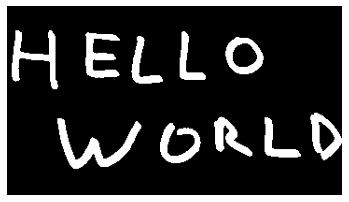

In [58]:
my_img = cv2.imread('/content/test_it.png', cv2.IMREAD_COLOR)
my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
min_threshold = 0.0 # change it according to your application
plt.imshow(preprocess.binarize(my_img), cmap= 'gray')
plt.axis('off')

In [59]:
output_img=preprocess.detectandlabel(my_model, my_img, my_labels, min_threshold)

(-0.5, 358.5, 201.5, -0.5)

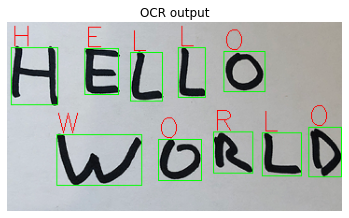

In [60]:
plt.imshow(output_img)
plt.title('OCR output')
plt.axis('off')


In [27]:
segs= preprocess.segment_characters(preprocess.binarize(my_img), padding=4)

(28, 28)


(-0.5, 27.5, 27.5, -0.5)

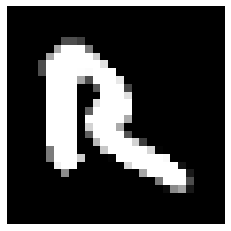

In [42]:
index = 3
bbox, subimg = segs[index]
print(subimg.shape)
plt.imshow(subimg, cmap = 'gray')
plt.axis('off')